In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Definição das Funções utilizadas
import cv2
import os
import joblib
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from google.colab.patches import cv2_imshow
from PIL import Image
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from keras.datasets import mnist
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.models import save_model, load_model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from tensorflow.keras import layers, regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2


output_path             = '/content/drive/MyDrive/Redes_Neurais/aug_data/'
model_save_path         = '/content/drive/MyDrive/Redes_Neurais/model_keras.h5'
classified_data_path    = '/content/drive/MyDrive/Redes_Neurais/digitos_classificados'
raw_digits_path         = '/content/drive/MyDrive/Redes_Neurais/digitos_originais/'
digits_path             = '/content/drive/MyDrive/Redes_Neurais/digitos/'
final_model_path        = '/content/drive/MyDrive/Redes_Neurais/final_model.h5'

classes = ['0','1','2','3','4','5','6','7','8','9']

def get_file_names(file):
    file_names = []
    for file_name in os.listdir(file):
        full_path = os.path.join(file, file_name)
        if os.path.isfile(full_path):
            file_names.append(file_name)
    return file_names

def extract_label(file_name):
    start_index = file_name.find('digit-') + len('digit-')
    end_index = file_name.find('-', start_index)
    if start_index != -1 and end_index != -1:
        return file_name[start_index:end_index]
    else:
        return None

def preprocess_image(image_path):

    image = cv2.imread(image_path)          # Carregar a imagem usando OpenCV
    image = cv2.resize(image, (28, 28))     # Redimensionar(28x28)

    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)   # Converter a imagem para escala de cinza
    image = image / 255.0    # Normalizar a imagem para ter valores no intervalo [0, 1]

    image = np.expand_dims(image, axis=-1)

    return image

In [ ]:
#Contar numero de imagens
num_imgs = 0
for file in os.listdir(raw_digits_path):
    if(file.endswith('jpg')):
        num_imgs+=1

for i in range(1,num_imgs+1):
    image_path = raw_digits_path + 'digito (' + str(i) + ').jpg'
    save_path  = digits_path + 'digito (' + str(i) + ').jpg'
    image = cv2.imread(image_path)
    grayscale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) # Convert the image to grayscale
    min_value = np.min(grayscale_image) # Find the minimum and maximum values in the grayscale image
    max_value = np.max(grayscale_image)
    normalized_image = (grayscale_image - min_value) / (max_value - min_value)    # Normalize the grayscale image
    whitened_image = np.where(normalized_image > 0.5, 255, 0)# Whiten the background of the image
    cv2.imwrite(save_path, whitened_image)


for i in range(1,num_imgs+1):
    image_path = raw_digits_path + 'digito (' + str(i) + ').jpg'
    save_path  = digits_path + 'digito (' + str(i) + ').jpg'
    image = cv2.imread('digito (' + str(i) + ').jpg', 0)
    kernel = np.ones((15,15), np.uint8)
    image = cv2.erode(image, kernel)
    cv2.imwrite(save_path, image)

In [ ]:
#Contar quantidade de digitos
num_imgs = 0
for file in os.listdir(digits_path):
    if(file.endswith('jpg')):
        num_imgs+=1

#Gerar dados aumentados
for i in range(1,num_imgs+1):
    image_path = digits_path + 'digito (' + str(i) + ').jpg'
    input_data = preprocess_image(image_path)
    input_data = np.expand_dims(input_data, axis=0)
    input_data = input_data.reshape(1, 28, 28, 1)

    # Para facilitar a geracao da label_list, adicionar a label ao nome do arquivo
    label = (i-1)%10
    name_prefix = 'digit-' + str(label) + '-'

    imgAug = ImageDataGenerator(rotation_range=25, width_shift_range=0.1, height_shift_range=0.1,
                                zoom_range=0.1, fill_mode='nearest', horizontal_flip=False)

    imgGen = imgAug.flow(input_data, save_to_dir=output_path, save_format='jpg', save_prefix=name_prefix)
    counter = 0
    for (j, newImage) in enumerate(imgGen):
        counter += 1
        if counter == 200:
            break

In [ ]:
def get_jpg_files(root_path):
    jpg_files = [file for file in os.listdir(root_path) if file.lower().endswith('.jpg')]
    return jpg_files

def plot_random_jpgs(root_path, num_images_to_plot):
    jpg_files = get_jpg_files(root_path)
    random_files = random.sample(jpg_files, num_images_to_plot)

    for file in random_files:
        file_path = os.path.join(root_path, file)
        image = Image.open(file_path)
        plt.imshow(image)
        plt.axis('off')
        plt.show()

def plot_random_jpgs_grayscale(root_path, num_images_to_plot, jpg_files):

    random_files = random.sample(jpg_files, num_images_to_plot)

    for file in random_files:
        file_path = os.path.join(root_path, file)
        image = Image.open(file_path).convert('L')  # Convert the image to grayscale
        plt.imshow(image, cmap='gray')
        plt.axis('off')
        plt.show()


root_path = output_path
jpg_files = get_jpg_files(root_path)
num_images_to_plot = 20  # Change this to the number of random images you want to plot
plot_random_jpgs_grayscale(root_path, num_images_to_plot, jpg_files)



In [ ]:
#populando a lista de labels dos dados aumentados
def extract_label(file_name):
    start_index = file_name.find('digit-') + len('digit-')
    end_index = file_name.find('-', start_index)
    if start_index != -1 and end_index != -1:
        return np.uint8(file_name[start_index:end_index])
    else:
        return None

label_list = []
for root, dirs, files in os.walk(output_path):
        for filename in files:
          label_list.append(extract_label(filename))

In [ ]:
#Carregar dataset a partir de imagens próprias aumentadas
x_new_train, x_new_test = tf.keras.utils.image_dataset_from_directory(output_path,
                                                                      labels=label_list,
                                                                      label_mode='categorical',
                                                                      color_mode="grayscale",
                                                                      image_size=(28, 28),
                                                                      shuffle=True,
                                                                      batch_size=1,
                                                                      validation_split=0.2,
                                                                      subset='both',
                                                                      seed=29)
#Convertendo os dados
x_n_train_array = []
y_n_train_array = []
x_n_test_array = []
y_n_test_array = []

for image, label in x_new_train:
    x_n_train_array.append(image.numpy())
    y_n_train_array.append(label.numpy())

x_train_aug = np.array(x_n_train_array)
y_train_aug = np.array(y_n_train_array)
x_train_aug = np.squeeze(x_train_aug, axis = 1)/255.0
y_train_aug = np.squeeze(y_train_aug)

for image, label in x_new_test:
    x_n_test_array.append(image.numpy())
    y_n_test_array.append(label.numpy())

x_test_aug = np.array(x_n_test_array)
y_test_aug = np.array(y_n_test_array)
x_test_aug = np.squeeze(x_test_aug, axis = 1)/255.0
y_test_aug = np.squeeze(y_test_aug)

In [ ]:
#Carregar dataset a partir de imagens próprias aumentadas
x_new_train, x_new_test = tf.keras.utils.image_dataset_from_directory(output_path,
                                                                      labels=label_list,
                                                                      label_mode='categorical',
                                                                      color_mode="grayscale",
                                                                      image_size=(28, 28),
                                                                      shuffle=True,
                                                                      batch_size=1,
                                                                      validation_split=0.2,
                                                                      subset='both',
                                                                      seed=29)
#Convertendo os dados
x_n_train_array = []
y_n_train_array = []
x_n_test_array = []
y_n_test_array = []

for image, label in x_new_train:
    x_n_train_array.append(image.numpy())
    y_n_train_array.append(label.numpy())

x_train_aug = np.array(x_n_train_array)
y_train_aug = np.array(y_n_train_array)
x_train_aug = np.squeeze(x_train_aug, axis = 1)/255.0
y_train_aug = np.squeeze(y_train_aug)

for image, label in x_new_test:
    x_n_test_array.append(image.numpy())
    y_n_test_array.append(label.numpy())

x_test_aug = np.array(x_n_test_array)
y_test_aug = np.array(y_n_test_array)
x_test_aug = np.squeeze(x_test_aug, axis = 1)/255.0
y_test_aug = np.squeeze(y_test_aug)

In [ ]:
# Carregar os dados MNIST
(x_train_mnist, y_train_mnist), (x_test_mnist, y_test_mnist) = mnist.load_data()

# Pré-processamento dos dados
x_train_mnist = x_train_mnist.reshape(60000, 28, 28, 1).astype('float32') / 255.0
x_test_mnist = x_test_mnist.reshape(10000, 28, 28, 1).astype('float32') / 255.0
y_train_mnist = np_utils.to_categorical(y_train_mnist, 10)
y_test_mnist = np_utils.to_categorical(y_test_mnist, 10)

In [ ]:
#Concatenar dados do MNIST com dados proprios
x_train = np.concatenate((x_train_mnist, x_train_aug), axis = 0)
x_test = np.concatenate((x_test_mnist, x_test_aug), axis = 0)
y_train = np.concatenate((y_train_mnist, y_train_aug), axis = 0)
y_test = np.concatenate((y_test_mnist, y_test_aug), axis = 0)

In [ ]:
################################################################################
#                        Rede Neural Convolucional                             #
################################################################################
model = Sequential()

# Primeira camada de convolução mais camada de pooling
model.add(Conv2D(128, (2, 2), activation = 'relu', padding='valid', input_shape=(28,28,1)))
model.add(MaxPooling2D(pool_size=(2, 2),strides=2))

# Segunda camada de convolução mais camada de pooling
model.add(Conv2D(512, (2, 2), activation = 'relu', padding='valid'))
model.add(MaxPooling2D(pool_size=(2, 2),strides=2))
model.add(Flatten())

# Camadas totalmente conectadas
model.add(Dense(512, activation='relu', bias_regularizer='l2'))
model.add(Dropout(0.4))

model.add(Dense(512, activation='relu', bias_regularizer='l2'))
model.add(Dropout(0.4))

model.add(Dense(512, activation='relu', bias_regularizer='l2'))
model.add(Dropout(0.4))

model.add(Dense(10, activation = 'softmax'))

#Imprime a arquitetura da rede
model.summary()

model.compile(optimizer="adam",loss="categorical_crossentropy", metrics=["accuracy"])

#Criterio de parada
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=7)

# Treinar o modelo
history = model.fit(x_train, y_train,
                    batch_size=256,
                    epochs=50,
                    verbose=1,
                    shuffle='true',
                    callbacks=[callback],
                    validation_data=(x_test, y_test))

# Plotar os graficos de loss e accuracy curves para o conjunto de treino e validação
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)
ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [ ]:
#Testar o modelo com os dados aumentados
#model = tf.keras.models.load_model('/content/Modelo_Final_Keras.h5')

data_array = []
for path, _, arquivo in os.walk(output_path):
    for data_file in arquivo:
        file_path = path + "/" + data_file
        image = preprocess_image(file_path)
        input_data = image
        input_data = np.expand_dims(input_data, axis=0)
        input_data = input_data.reshape(1, 28, 28, 1)
        data_array.append(input_data)

for data in data_array:
    output = model.predict(data)
    print("Previsão: ", np.argmax(output))
    print(output)

    plt.figure(figsize=(4, 2))
    plt.imshow(data.reshape(28, 28), cmap=plt.cm.Greys)
    plt.show()

In [ ]:
#salvar modelo
model.save(model_save_path, overwrite=True, save_format="h5")

372/372 [==============================] - 1s 2ms/step
Accuracy:  0.858427
Precision: 0.858427
Recall:    0.858427
F1 score:  0.858427


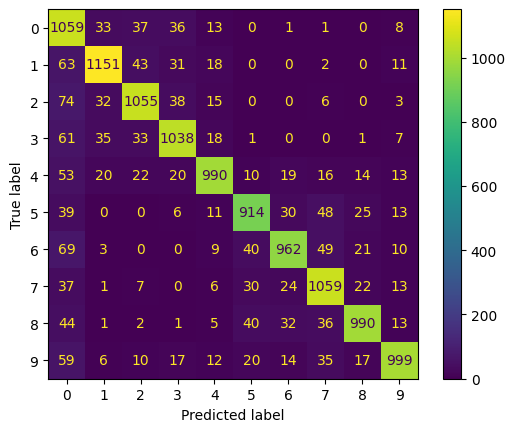

In [ ]:
# Fazer as previsões com o modelo
# MNIST + aug
yhat_probs = model.predict(x_test)
y_true     = np.argmax(np.round(y_test), axis=1)
y_pred     = np.argmax(np.round(yhat_probs), axis=1)

# Calcular as métricas
accuracy  = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='micro')
recall    = recall_score(y_true, y_pred, average='micro')
f1        = f1_score(y_true, y_pred, average='micro')
matrix    = confusion_matrix(y_true, y_pred, labels=np.arange(len(classes)))

# Imprimir as métricas
print('Accuracy:  %f' % accuracy)
print('Precision: %f' % precision)
print('Recall:    %f' % recall)
print('F1 score:  %f' % f1)

# Plotar gráfico da matriz de confusão
display = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=classes)
display.plot()

313/313 [==============================] - 1s 2ms/step
Accuracy:  0.990800
Precision: 0.990800
Recall:    0.990800
F1 score:  0.990800


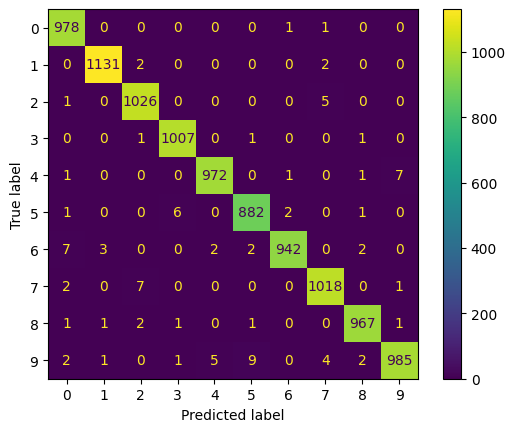

In [ ]:
# Fazer as previsões com o modelo
# MNIST
yhat_probs = model.predict(x_test_mnist)
y_true     = np.argmax(np.round(y_test_mnist), axis=1)
y_pred     = np.argmax(np.round(yhat_probs), axis=1)

# Calcular as métricas
accuracy  = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='micro')
recall    = recall_score(y_true, y_pred, average='micro')
f1        = f1_score(y_true, y_pred, average='micro')
matrix    = confusion_matrix(y_true, y_pred, labels=np.arange(len(classes)))

# Imprimir as métricas
print('Accuracy:  %f' % accuracy)
print('Precision: %f' % precision)
print('Recall:    %f' % recall)
print('F1 score:  %f' % f1)

# Plotar gráfico da matriz de confusão
display = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=classes)
display.plot()

60/60 [==============================] - 0s 2ms/step
Accuracy:  0.162461
Precision: 0.162461
Recall:    0.162461
F1 score:  0.162461


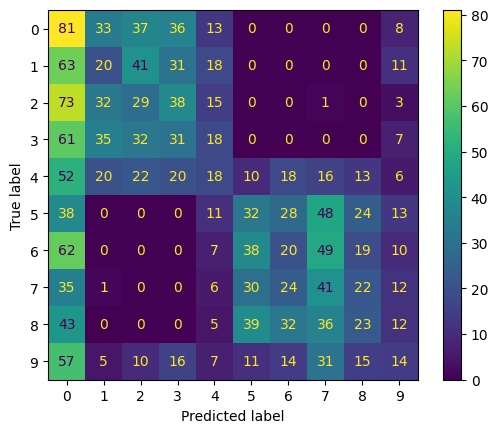

In [ ]:
# Fazer as previsões com o modelo
# aug
yhat_probs = model.predict(x_test_aug)
y_true     = np.argmax(np.round(y_test_aug), axis=1)
y_pred     = np.argmax(np.round(yhat_probs), axis=1)

# Calcular as métricas
accuracy  = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='micro')
recall    = recall_score(y_true, y_pred, average='micro')
f1        = f1_score(y_true, y_pred, average='micro')
matrix    = confusion_matrix(y_true, y_pred, labels=np.arange(len(classes)))

# Imprimir as métricas
print('Accuracy:  %f' % accuracy)
print('Precision: %f' % precision)
print('Recall:    %f' % recall)
print('F1 score:  %f' % f1)

# Plotar gráfico da matriz de confusão
display = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=classes)
display.plot()